Assignment 1: Discriminative vs Generative Models

This notebook compares a discriminative model (Logistic Regression) and a generative model (GAN) using the MNIST dataset.


In [1]:
# Importing PyTorch and other necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Transforming images to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixels to [-1, 1]
])

Dataset: MNIST

The MNIST dataset contains grayscale images of handwritten digits from 0 to 9.
The dataset is normalized and loaded using PyTorch DataLoaders.


In [3]:
# Load MNIST training and test datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',   # Folder to store the dataset
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [4]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

Data Visualization

The following images are samples from the MNIST dataset to confirm it loaded correctly.


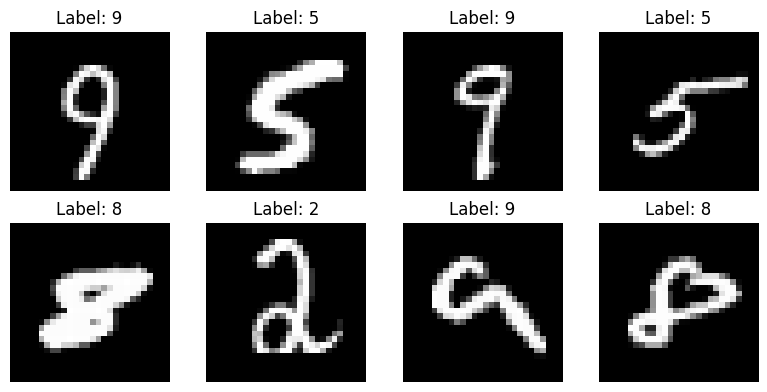

In [5]:
# Getting some sample images
examples = iter(train_loader)
images, labels = next(examples)

# Plotting 8 sample images
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # Remove extra channel dimension
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Load and preprocess MNIST dataset

In [6]:
# Flattening MNIST images
input_dim = 28 * 28  # 28x28 pixels
num_classes = 10      # digits 0-9

Discriminative Model: Logistic Regression

This model predicts the digit label directly from image pixels.
Images are flattened before being passed into the model.


In [7]:
import torch.nn as nn

# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)  # Linear layer

    def forward(self, x):
        return self.linear(x)  # Output raw scores (logits)


In [8]:
# Create the model
model = LogisticRegressionModel(input_dim, num_classes)

# Loss function
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Auto-adjusts weights


Training the Logistic Regression Model

The model is trained using cross-entropy loss and Adam optimization.
Training accuracy is printed after each epoch.


In [9]:
num_epochs = 5  # Number of training rounds

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Flatten images: [batch_size, 1, 28,28] -> [batch_size, 784]
        images = images.view(-1, 28*28)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

Epoch [1/5], Loss: 0.5437, Accuracy: 85.25%
Epoch [2/5], Loss: 0.3399, Accuracy: 90.22%
Epoch [3/5], Loss: 0.3154, Accuracy: 90.97%
Epoch [4/5], Loss: 0.3039, Accuracy: 91.27%
Epoch [5/5], Loss: 0.2965, Accuracy: 91.61%


Implement and train Logistic Regression on MNIST

In [10]:
import torch.nn.functional as F

Generative Model: GAN

The GAN includes a generator and a discriminator.
The generator creates fake images using random noise.


In [11]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [13]:
noise_dim = 100

generator = Generator(noise_dim)
discriminator = Discriminator()

criterion = nn.BCELoss()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

Training the GAN

The discriminator and generator are trained alternately.
Loss values fluctuate due to adversarial training.


In [14]:
num_epochs = 20

for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        batch_size = real_images.size(0)

        # ======================
        # Train Discriminator
        # ======================
        real_images = real_images.view(batch_size, -1)

        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, noise_dim)
        fake_images = generator(noise)

        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ======================
        # Train Generator
        # ======================
        noise = torch.randn(batch_size, noise_dim)
        fake_images = generator(noise)

        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [1/20]  D Loss: 0.0942, G Loss: 7.0292
Epoch [2/20]  D Loss: 1.0335, G Loss: 4.8576
Epoch [3/20]  D Loss: 0.1517, G Loss: 5.5577
Epoch [4/20]  D Loss: 0.3211, G Loss: 4.2535
Epoch [5/20]  D Loss: 0.5078, G Loss: 4.9161
Epoch [6/20]  D Loss: 0.0469, G Loss: 5.4287
Epoch [7/20]  D Loss: 0.2689, G Loss: 4.2555
Epoch [8/20]  D Loss: 0.0328, G Loss: 6.0111
Epoch [9/20]  D Loss: 0.0840, G Loss: 6.7368
Epoch [10/20]  D Loss: 0.1981, G Loss: 3.9535
Epoch [11/20]  D Loss: 0.0654, G Loss: 6.2024
Epoch [12/20]  D Loss: 0.3052, G Loss: 5.7130
Epoch [13/20]  D Loss: 0.0658, G Loss: 5.9380
Epoch [14/20]  D Loss: 0.1895, G Loss: 6.3846
Epoch [15/20]  D Loss: 0.2274, G Loss: 6.4499
Epoch [16/20]  D Loss: 0.1771, G Loss: 5.0234
Epoch [17/20]  D Loss: 0.2166, G Loss: 4.5566
Epoch [18/20]  D Loss: 0.2728, G Loss: 4.3092
Epoch [19/20]  D Loss: 0.1779, G Loss: 3.9336
Epoch [20/20]  D Loss: 0.3664, G Loss: 4.9064


Generated Images

These images are generated by the GAN after training.
Image quality improves gradually but may remain imperfect.


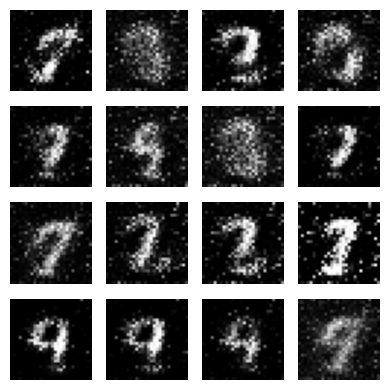

In [16]:
noise = torch.randn(16, noise_dim)
generated_images = generator(noise).view(-1, 28, 28)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].detach(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()